In [2]:
import os
import re, math
import time
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
import cv2
import seaborn as sns
sns.set()

In [3]:
# check TF version (want: 2.3)
print(tf.__version__)

2.18.0


In [4]:
BASE_DIR = './'

FILE_LABELS = os.path.join(BASE_DIR, 'trainLabels.csv')
TRAIN_IMAGES_DIR = os.path.join(BASE_DIR, 'train')

TFREC_DIR = os.path.join(BASE_DIR, 'tfrec')

In [5]:
df_labels = pd.read_csv(FILE_LABELS)

df_labels.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


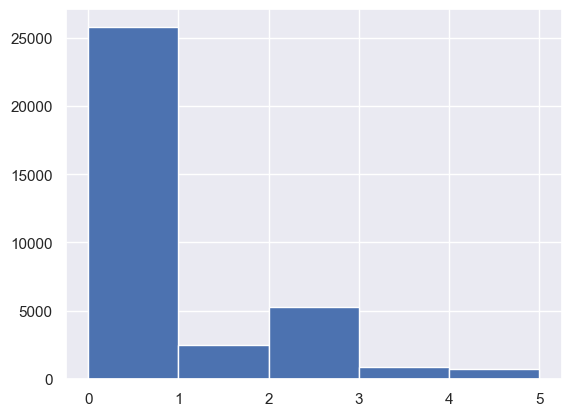

In [6]:
df_labels.level.hist(bins = [0,1,2,3,4,5]);

In [7]:
df_labels.groupby(['level']).size()

level
0    25810
1     2443
2     5292
3      873
4      708
dtype: int64

In [7]:
# codice preparazione file tfrecord

In [9]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    
            img = np.stack([img1,img2,img3],axis=-1)
    
        return img

def preprocess_image(image, crop=False, blur = False, sigmaX=10):
    # CV2 per default tratta le immagini come BGR
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if crop == True:
        image = crop_image_from_gray(image)
    
    image = cv2.resize(image, (IMG_PIXEL, IMG_PIXEL), interpolation = cv2.INTER_AREA)
    
    if blur == True:
        image = cv2.addWeighted (image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
    
    return image

In [10]:
# utility functions from TF2 docs
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [11]:
def serialize_example(img, patient_id, side, label):
  feature = {
      'image': _bytes_feature(img),
      'patient_id': _int64_feature(patient_id),
      'side': _int64_feature(side),       # 0,1, left,right
      'label': _int64_feature(label) # [0, 4]
  }
  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

In [ ]:
# how many imgs in file
SIZE = 2000

IMG_PIXEL = 512

# dataframe where to take metadata
df = df_labels 

# imgs to process
IMGS = df['image'].values

CT = len(IMGS)//SIZE + int(len(IMGS)%SIZE!=0)

count = 0

for j in range(CT):
    print(); 
    print('Writing TFRecord %i of %i...'%(j+1, CT))
    
    tStart = time.time()
    
    CT2 = min(SIZE, len(IMGS)-j*SIZE)
    
    with tf.io.TFRecordWriter(os.path.join(TFREC_DIR, 'train%.2i-%i.tfrec'%(j,CT2))) as writer:
        for k in range(CT2):
            index = SIZE*j+k
            img_path = os.path.join(TRAIN_IMAGES_DIR, df.iloc[index].image) + '.jpeg'
            
            img = cv2.imread(img_path)
            
            # per default CV2 legge in BGR
        
            # img = cv2.resize(img, (IMG_PIXEL, IMG_PIXEL), interpolation = cv2.INTER_AREA)
            img = preprocess_image(img, crop=True, blur = True, sigmaX=10)
            
            # potrei cambiare la qualità !!! portarla al 100%
            img = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, 94))[1].tobytes()
            
            name = IMGS[index]
            
            # get the row from Dataframe
            row = df.iloc[index]
            
            # get patientId
            patientID = int(row['image'].split('_')[0])
            
            # encode side: left = 0, right = 1
            if 'left' in row['image']:
                side = 0
            else:
                side = 1
            
            level = row['level']
            
            # build the record
            # image, patientid, side, label
            example = serialize_example(img, patientID, side, level)
                
            writer.write(example)
            
            # print progress
            if k%100==0: print('#','',end='')
                
    tEnd = time.time()
    
    print('')
    print('Elapsed: ', round((tEnd - tStart),1), ' (sec)')


Writing TFRecord 1 of 18...
# # # # # # # # # # # # # # # # # # # # 
Elapsed:  697.6  (sec)

Writing TFRecord 2 of 18...
# # # # # # # # # # # 

In [ ]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [ ]:
TRAIN_FILENAMES = tf.io.gfile.glob(os.path.join(TFREC_DIR,'train*.tfrec'))

TRAIN_FILENAMES

[]

In [23]:
# contiamo il totale delle immagini (dai nomi)
count_data_items(TRAIN_FILENAMES)

0.0

In [27]:
imSize = 256
IMAGE_SIZE= [256,256]
BATCH_SIZE = 256

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    # porto a 256x256
    # image = tf.image.resize(image, [imSize,imSize])
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        'patient_id' : tf.io.FixedLenFeature([], tf.int64), 
        'side' : tf.io.FixedLenFeature([], tf.int64),
        'label' : tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    
    image = decode_image(example['image'])
    patient_id = example['patient_id']
    side = example['side']
    label = example['label']
    
    return image, label

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def get_training_dataset(filenames):
    dataset = load_dataset(filenames, labeled=True)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

In [28]:
AUTO = tf.data.experimental.AUTOTUNE

train_dataset = get_training_dataset(TRAIN_FILENAMES)
train_dataset = train_dataset.unbatch().batch(20)
train_batch = iter(train_dataset)

In [29]:
print('Test: reading TFREcords file...')
print("Examples of the train data:")

print()

batch_num = 0

for image, label in train_dataset.take(5):
    batch_num += 1
    print('')
    print('Batch num. ', batch_num)
    print("The image batch size:", image.numpy().shape)
    print("Label", label.numpy())

Test: reading TFREcords file...
Examples of the train data:



In [ ]:
# OK, seems OK